Импортируем необходимые библиотеки.

In [2]:
#Обновляем kaggle_environments перед импортом
!pip install -q -U kaggle_environments 

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Создадим 12 агентов:  
1. rock_agent - Всегда камень.  
2. paper_agent - Всегда бумага.  
3. scissors_agent - Всегда ножницы.  
4. copy_opponent_agent - Копирование предыдущего хода оппонента. Первый ход случайным образом.  
5. lag_agent - Выбор варианта, побеждающего предыдущий ход оппонента. Первый ход случайным образом.  
6. circle_agent - Первый раунд случайный, далее по кругу.  
7. rand_agent - Всегда случайный выбор.  
8. skew_rand_agent - 10% - камень, 20% - бумага, 70% - ножницы.  
9. third_move_agent - Выбирается вариант, которого не было у игроков на предыдущем ходе. Первый ход случайным образом.  
10. givup - Выбирает вариант, проигрывающий предыдущему ходу оппонента. Первый ход случайным образом. 
11. confirmation - Если предыдущий раунд был выигрышным или ничейным, то повторяет то же действие, иначе меняет решение на случайное, отличающееся от предыдущего хода. Первый ход случайным образом.  
12. unconfirmation - Если предыдущий раунд был выигрышным или ничейным, то меняет решение на случайное, отличающееся от предыдущего хода, иначе повторяет то же действие. Первый ход случайным образом.  
13. counter_reactionary - Воспользуемся агентом из библиотеки kaggle_environments. Агент использует контр-стратегию против lag_agent.  
14. statistical - Воспользуемся агентом из библиотеки kaggle_environments. Агент подбирает ход, который выигрывает наиболее часто встречающегося варианта хода оппонента.    

0 - камень  
1 - бумага  
2 - ножницы  

In [3]:
%%writefile rock_agent.py
# 1. Всегда камень.
def rock_agent(observation, configuration):
    return 0

Writing rock_agent.py


In [4]:
%%writefile paper_agent.py
# 2. Всегда бумага.
def paper_agent(observation, configuration):
    return 1

Writing paper_agent.py


In [5]:
%%writefile scissors_agent.py
# 3. Всегда ножницы.
def scissors_agent(observation, configuration):
    return 2

Writing scissors_agent.py


In [6]:
%%writefile copy_opponent_agent.py
# 4. Копирование предыдущего хода оппонента. Первый ход случайным образом.
import numpy as np
def copy_opponent_agent(observation, configuration):
    if observation.step > 0:
        result = observation.lastOpponentAction # если это не первый ход, то возвращается предыдущее действие оппонента
    else:
        result = np.random.randint(0, 3) # если это первый ход, то случайное решение
    return result

Writing copy_opponent_agent.py


In [7]:
%%writefile lag_agent.py
# 5. Выбор варианта, побеждающего предыдущий ход оппонента. Первый ход случайным образом.
import numpy as np
def lag_agent(observation, configuration):
    if observation.step > 0:
        result = (observation.lastOpponentAction + 1) % 3 # если это не первый ход, то возвращается предыдущее действие оппонента
    else:
        result = np.random.randint(0, 3) # если это первый ход, то случайное решение
    return result

Writing lag_agent.py


In [8]:
%%writefile circle_agent.py
# 6. Первый раунд случайный, далее по кругу
import numpy as np
my_last_action = 0
def circle_agent(observation, configuration):
    global my_last_action
    if observation.step > 0:
        result = (my_last_action + 1) % 3 # если это не первый ход, то возвращается предыдущее действие оппонента
    else:
        result = np.random.randint(0, 3) # если это первый ход, то случайное решение
    my_last_action = result
    return result

Writing circle_agent.py


In [9]:
%%writefile rand_agent.py
# 7. Всегда случайный выбор
import numpy as np
def rand_agent(observation, configuration):
    return np.random.randint(0, 3) # случайное решение
    

Writing rand_agent.py


In [10]:
%%writefile scew_rand_agent.py
# 8. 10% - камень, 20% - бумага, 70% - ножницы
import numpy as np
def scew_rand_agent(observation, configuration):
    values = [0, 1, 2] # значения
    probabilities = [0.1, 0.2, 0.7] # вероятности
    return int(np.random.choice(values, p=probabilities))


Writing scew_rand_agent.py


In [11]:
%%writefile third_move_agent.py
# 9. Выбирается вариант, которого не было у игроков на предыдущем ходе. Первый ход случайным образом
import numpy as np
my_last_action = 0
def third_move_agent(observation, configuration):
    global my_last_action
    if observation.step > 0:
        actions = {0, 1, 2}
        missing_actions = list(actions.difference({my_last_action}).difference({observation.lastOpponentAction})) # список значений, которые не использовались на предыдущем ходе
        result = int(np.random.choice(missing_actions)) # выбор случайным образом из значений, которые не использовались на предыдущем ходе
    else:
        result = np.random.randint(0, 3) # если это первый ход, то случайное решение
    my_last_action = result
    return result

Writing third_move_agent.py


In [12]:
%%writefile givup_agent.py
# 10. Выбирает вариант, проигрывающий предыдущему ходу оппонента. Первый ход случайным образом.
import numpy as np
def givup_agent(observation, configuration):
    if observation.step > 0:
        result = (observation.lastOpponentAction + 2) % 3 # если это не первый ход, то возвращается предыдущее действие оппонента
    else:
        result = np.random.randint(0, 3) # если это первый ход, то случайное решение
    return result

Writing givup_agent.py


In [13]:
%%writefile confirmation_agent.py
# 11. Если предыдущий раунд был выигрышным или ничейным, то повторяет то же действие, иначе меняет решение на случайное, отличающееся от предыдущего хода. Первый ход случайным образом.
import numpy as np
import math

my_last_action = 0

def check_result(move1, move2):
    delta = (
        move2 - move1
        if (move1 + move2) % 2 == 0
        else move1 - move2
    )
    return 0 if delta == 0 else math.copysign(1, delta)

def confirmation_agent(observation, configuration):
    global my_last_action
    if observation.step > 0:
        if check_result(my_last_action, observation.lastOpponentAction) >= 0:
            result = my_last_action
        else:
            actions = {0, 1, 2}
            missing_actions = list(actions.difference({my_last_action})) # список значений, которые не использовались на предыдущем ходе
            result = int(np.random.choice(missing_actions)) # выбор случайным образом из значений, которые не использовались на предыдущем ходе
    else:
        result = np.random.randint(0, 3) # если это первый ход, то случайное решение
    my_last_action = result
    return result

Writing confirmation_agent.py


In [14]:
%%writefile unconfirmation_agent.py
# 12. Если предыдущий раунд был выигрышным или ничейным, то меняет решение на случайное, отличающееся от предыдущего хода, иначе повторяет то же действие. Первый ход случайным образом.
import numpy as np
import math

my_last_action = 0

def check_result(move1, move2):
    delta = (
        move2 - move1
        if (move1 + move2) % 2 == 0
        else move1 - move2
    )
    return 0 if delta == 0 else math.copysign(1, delta)

def unconfirmation_agent(observation, configuration):
    global my_last_action
    if observation.step > 0:
        if check_result(my_last_action, observation.lastOpponentAction) < 0:
            result = my_last_action
        else:
            actions = {0, 1, 2}
            missing_actions = list(actions.difference({my_last_action})) # список значений, которые не использовались на предыдущем ходе
            result = int(np.random.choice(missing_actions)) # выбор случайным образом из значений, которые не использовались на предыдущем ходе
    else:
        result = np.random.randint(0, 3) # если это первый ход, то случайное решение
    my_last_action = result
    return result

Writing unconfirmation_agent.py


Запустим турнир между всеми игроками, в котором каждый агент сыграет с каждым по 200 раундов.

Начинаем турнир.
LOG: start game rock_agent.py vs paper_agent.py
LOG: game result rock_agent.py vs paper_agent.py: -200:200
LOG: start game rock_agent.py vs scissors_agent.py
LOG: game result rock_agent.py vs scissors_agent.py: 200:-200
LOG: start game rock_agent.py vs copy_opponent_agent.py
LOG: game result rock_agent.py vs copy_opponent_agent.py: 0:0
LOG: start game rock_agent.py vs lag_agent.py
LOG: game result rock_agent.py vs lag_agent.py: -199:199
LOG: start game rock_agent.py vs circle_agent.py
LOG: game result rock_agent.py vs circle_agent.py: -1:1
LOG: start game rock_agent.py vs rand_agent.py
LOG: game result rock_agent.py vs rand_agent.py: 17:-17
LOG: start game rock_agent.py vs scew_rand_agent.py
LOG: game result rock_agent.py vs scew_rand_agent.py: 112:-112
LOG: start game rock_agent.py vs third_move_agent.py
LOG: game result rock_agent.py vs third_move_agent.py: 0:0
LOG: start game rock_agent.py vs givup_agent.py
LOG: game result rock_agent.py vs givup_agent.py: 198:-198


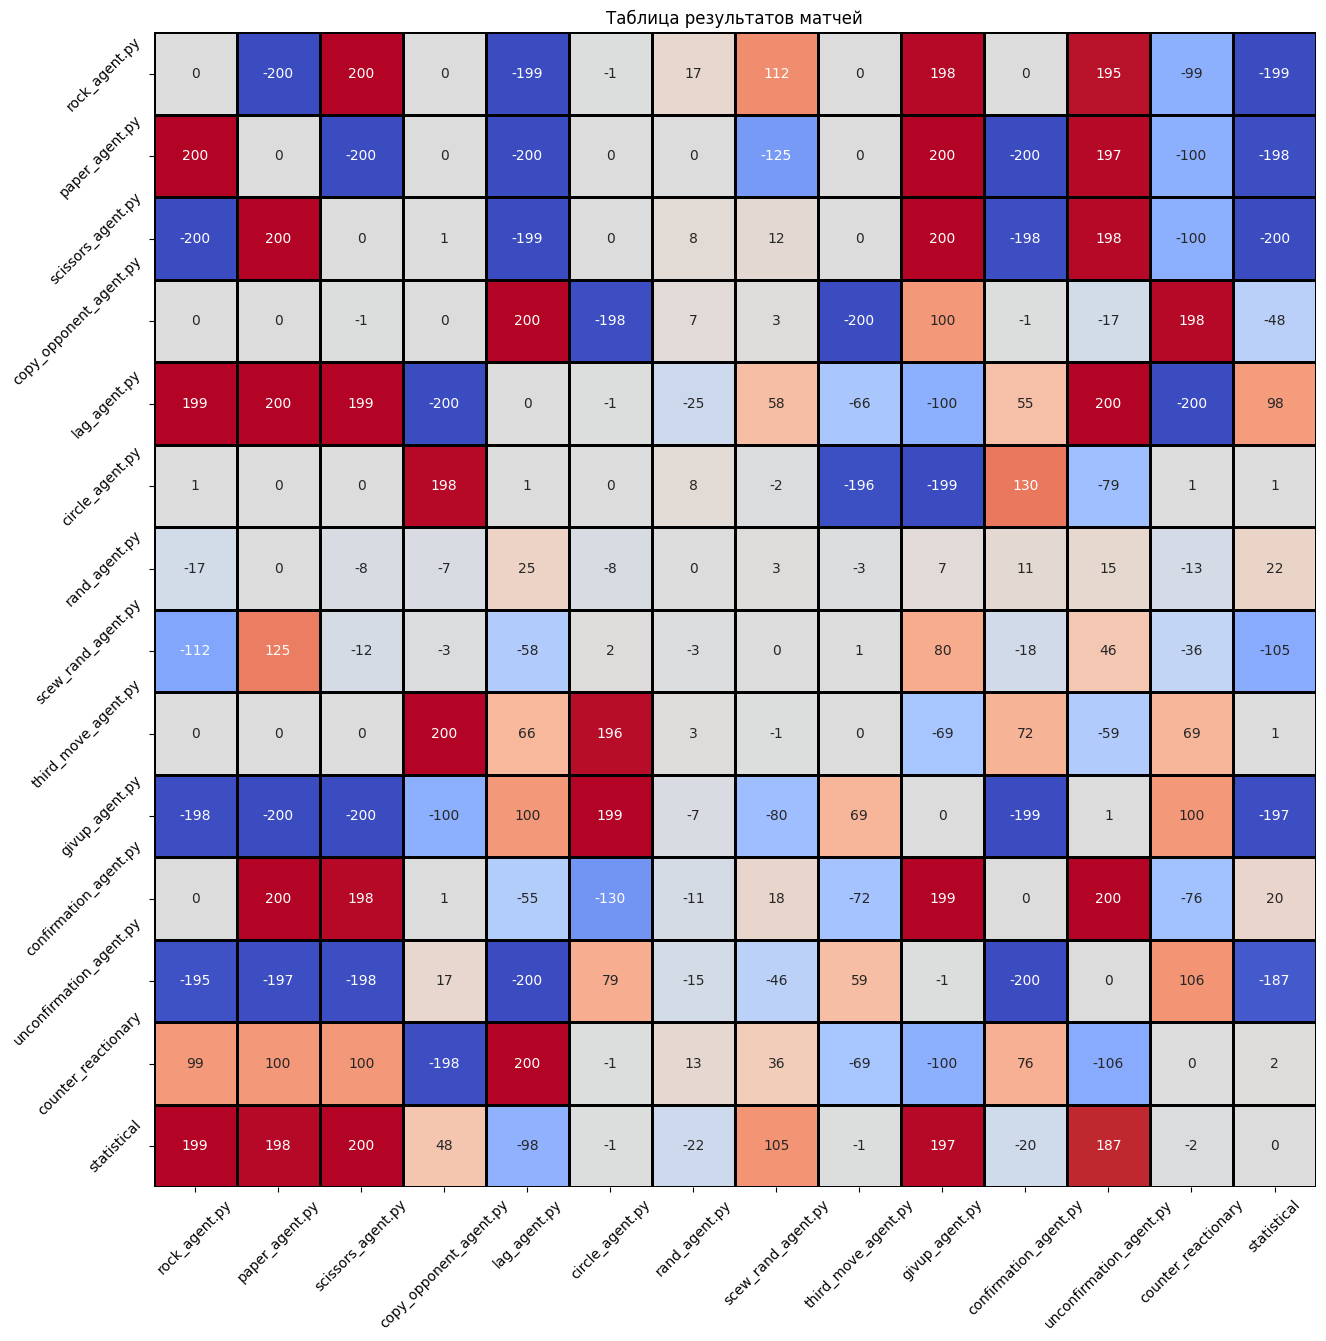

In [18]:
# список агентов, участвующих в турнире
list_agents = [
    "rock_agent.py", 
    "paper_agent.py", 
    "scissors_agent.py",
    "copy_opponent_agent.py",
    "lag_agent.py",
    "circle_agent.py",
    "rand_agent.py",
    "scew_rand_agent.py",
    "third_move_agent.py",
    "givup_agent.py",
    "confirmation_agent.py",
    "unconfirmation_agent.py",
    "counter_reactionary",
    "statistical"
]

# количество раундов в играх между каждыми двумя агентами
n_rounds = 200 + 1 # (+ 1) - так как эмуляция evaluate (run) в первой партии всегда возвращает 0 для любого агента, то есть первая партия не идёт в зачёт.

# число агентов
n_agents = len(list_agents)

# заполняем таблицу очков размера n_agents x n_agents нулями
scores = np.zeros((n_agents, n_agents), dtype=np.int32)

print("Начинаем турнир.")

for ind_agent_1 in range(len(list_agents)): # цикл по агентам
    for ind_agent_2 in range(ind_agent_1 + 1, len(list_agents)): # цикл по остальным агентам
        # вывод лога
        print(f"LOG: start game {list_agents[ind_agent_1]} vs {list_agents[ind_agent_2]}")

        # игра между агентами
        env = make(
            "rps", 
            configuration={
                "episodeSteps": n_rounds
            }
        )
        env.run(
            [list_agents[ind_agent_1], list_agents[ind_agent_2]]
        )

        # проверяем, что игра не завершилась с ошибкой
        if env.steps[-1][0].status == 'INVALID' or env.steps[-1][0].status == 'INVALID':
            print(f"LOG: game result {list_agents[ind_agent_1]} vs {list_agents[ind_agent_2]}: ERROR {env.steps[-1][0].status}, {env.steps[-1][0].status}")
            score = np.nan
        else:
            score = env.steps[-1][0].observation.reward

        scores[ind_agent_1, ind_agent_2] = score # количество очков первого агента
        scores[ind_agent_2, ind_agent_1] = -score # количество очков второго агента
        print(f"LOG: game result {list_agents[ind_agent_1]} vs {list_agents[ind_agent_2]}: {score}:{-score}")

print("Турнир окончен.")

# Визуализация
df_scores = pd.DataFrame(
    scores, 
    index=list_agents, 
    columns=list_agents,
)
plt.figure(figsize=(15, 15))
sns.heatmap(df_scores, annot=True, cbar=False, cmap='coolwarm', linewidths=1, linecolor='black', fmt='d')
plt.title('Таблица результатов матчей')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


In [19]:
#Выведем турнирную таблицу, где за победу в матче дают 3 очка, за ничью 1, за проигрыш 0
df_tournament_table = pd.DataFrame(data=[[-1]*len(list_agents)], columns=list_agents) # создаём турнирную таблицу
df_tournament_table.index = ["tournament_1"] # единственную строку назовём "tournament_1"
for row_index in range(df_scores.shape[0]):  
    value = 0
    for col_index in range(df_scores.shape[1]):
        if row_index != col_index: # диагональные элементы не учитываются
            x = df_scores.iloc[row_index, col_index]
            value += 3 if x > 0 else 1 if x == 0 else 0 # считаем количество наранных очков
    df_tournament_table.loc["tournament_1", df_scores.index[row_index]] = value

sorted_columns = df_tournament_table.loc["tournament_1"].sort_values(ascending=False).index # сортируем по набранным очкам
display(df_tournament_table[sorted_columns].T)


,tournament_1
third_move_agent.py,24
counter_reactionary,24
circle_agent.py,23
confirmation_agent.py,22
lag_agent.py,21
statistical,21
scissors_agent.py,20
rand_agent.py,19
rock_agent.py,18
copy_opponent_agent.py,17
